In [2]:
# computational libraries
import datetime as DT
import io
import os;
import pandas as pd;
import numpy as np

# data modeling libraries
from rfpimp import permutation_importances
import scipy
from scipy.stats import chisquare
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smlog
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

# visualization libraries
import matplotlib.pyplot as plt
plt.style.use('classic')
from yellowbrick.regressor import PredictionError, ResidualsPlot
from yellowbrick.regressor.alphas import AlphaSelection
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import PredictionError
import seaborn as sns
import graphviz

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
from IPython.core.pylabtools import figsize

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

# output formatting
custom_css={'width': '50%'}

# PyMC3 for Bayesian Inference
import pymc3 as pm

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> our learning project

### our goal:
- if you give me the features for a given machine & job type, I should be able to predict it's speed. 
- amount of time a machine is off during machine run time is a core predictor of speed, thus we will build a primary model to predict perc_time_machine_off based on job / machine attributes and feed that to the secondary model which will predict job speed.
- the goal of this project is to understand what variables most strongly predict speed & build a model that suggests how we would be able to do this at a production level

### Phase 1: 
- come up with a playbook for "cleansing" machine data
- use multilinear regression to gage ability to describe variance in speed with features engineered
- determine most powerful variables that influence speed (random forest [RF] & ordinary least squares [OLS])

### Phase 2:
- optimize for the business problem of predicting speed given machine / job attributes available before running the job
- generate visualizations that explain decisions / assumptions made in data modeling process
- see how accurate we can be in our predictions given the limitations above

### Phase 3:
- improve the predictability of the model to the best of our ability given time constraints
- come up with directions for next steps

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Data Discovery & Treatment

In [3]:
# read in fake data
data = pd.read_csv('./file_for_alda.csv')
# we will use the following for EPA (exploratory data analysis), and make changes to data, which is used for modeling
df = data

### the variable of interest is continuous, speed_std. let's first take a look at its distribution & check for skew:

Text(0.5, 1.0, 'Distribution of standard speed')

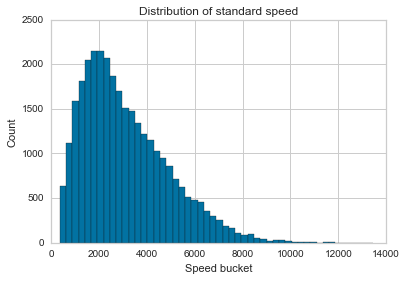

In [4]:
plt.hist(df['speed_std'], bins = 50)
plt.xlabel('Speed bucket')
plt.ylabel('Count')
plt.title('Distribution of standard speed')

the distribution looks chi-squared, or like a left-skewed normal distribution. It's very likely that some of our categorical variables are skewing predictions. to look at categorical variables' impact on speed we can make density plots of the speed distribution colored by the value of the categorical variable. the kdeplot function is awesome @ this!

Text(0.5, 1.0, 'Density Plot of Speed Std by Machine Model')

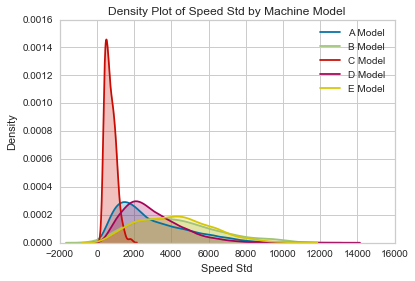

In [5]:
# Make one plot for each different location
sns.kdeplot(df.loc[df['machine_model'] == 'MM_A', 'speed_std'], 
            label = 'A Model', shade = True)
sns.kdeplot(df.loc[df['machine_model'] == 'MM_B', 'speed_std'], 
            label = 'B Model', shade = True)
sns.kdeplot(df.loc[df['machine_model'] == 'MM_C', 'speed_std'], 
            label = 'C Model', shade = True)
sns.kdeplot(df.loc[df['machine_model'] == 'MM_D', 'speed_std'], 
            label = 'D Model', shade = True)
sns.kdeplot(df.loc[df['machine_model'] == 'MM_E', 'speed_std'], 
            label = 'E Model', shade = True)

# Add labeling
plt.xlabel('Speed Std')
plt.ylabel('Density')
plt.title('Density Plot of Speed Std by Machine Model')

C models might need to be removed from our analysis. looks like D&A are left skewed & E & B are more close to normally districuted

Text(0.5, 1.0, 'Density Plot of Speed Std by Work Type')

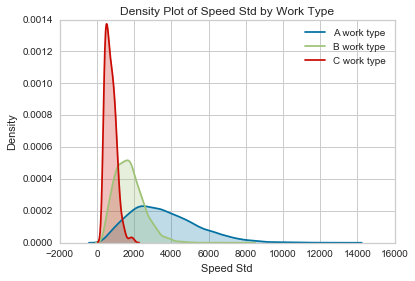

In [6]:
# Make one plot for each different location
sns.kdeplot(df.loc[df['work_type'] == 'A', 'speed_std'], 
            label = 'A work type', shade = True)
sns.kdeplot(df.loc[df['work_type'] == 'B', 'speed_std'], 
            label = 'B work type', shade = True)
sns.kdeplot(df.loc[df['work_type'] == 'C', 'speed_std'], 
            label = 'C work type', shade = True)


# Add labeling
plt.xlabel('Speed Std')
plt.ylabel('Density')
plt.title('Density Plot of Speed Std by Work Type')

A work types have a wider ranges of speed... C work types look mega borked. & work type seems to be one of our main predictors. we will later see whether specific jobs are going to the same machines, and look at the relationship between these variables

### a naive focus on the continuous variables
look at the variables that are highly correlated with your target variable and prioritize shaping those continuous variables into features!

In [7]:
df.corr()['speed_std'].sort_values()

bucket_size_avg      -0.436987
off_time_s           -0.243928
on_time_ct           -0.025472
off_time_ct          -0.024689
total_time_total_s   -0.000184
ck_barcode            0.023076
Unnamed: 0            0.067487
bucket_adds_avg       0.100376
on_time_total_s       0.226570
ck_data_capture       0.253013
on_time_s             0.323792
on_units_total        0.421728
total_units_total     0.427267
speed_rated           0.777507
speed_std             1.000000
Name: speed_std, dtype: float64

given our business problem, we know that we will not be able to choose as features any variable that is not available to us until the job runs. that means that our short list of continuous variables that we can use for this project are: 
### bucket_size_avg, bucket_adds_avg, total_units_total

we will do this same process later on with categorical variables once we binerify them (or one-hot encode, or dummify them... ugh why are there so many names for the same thing!)

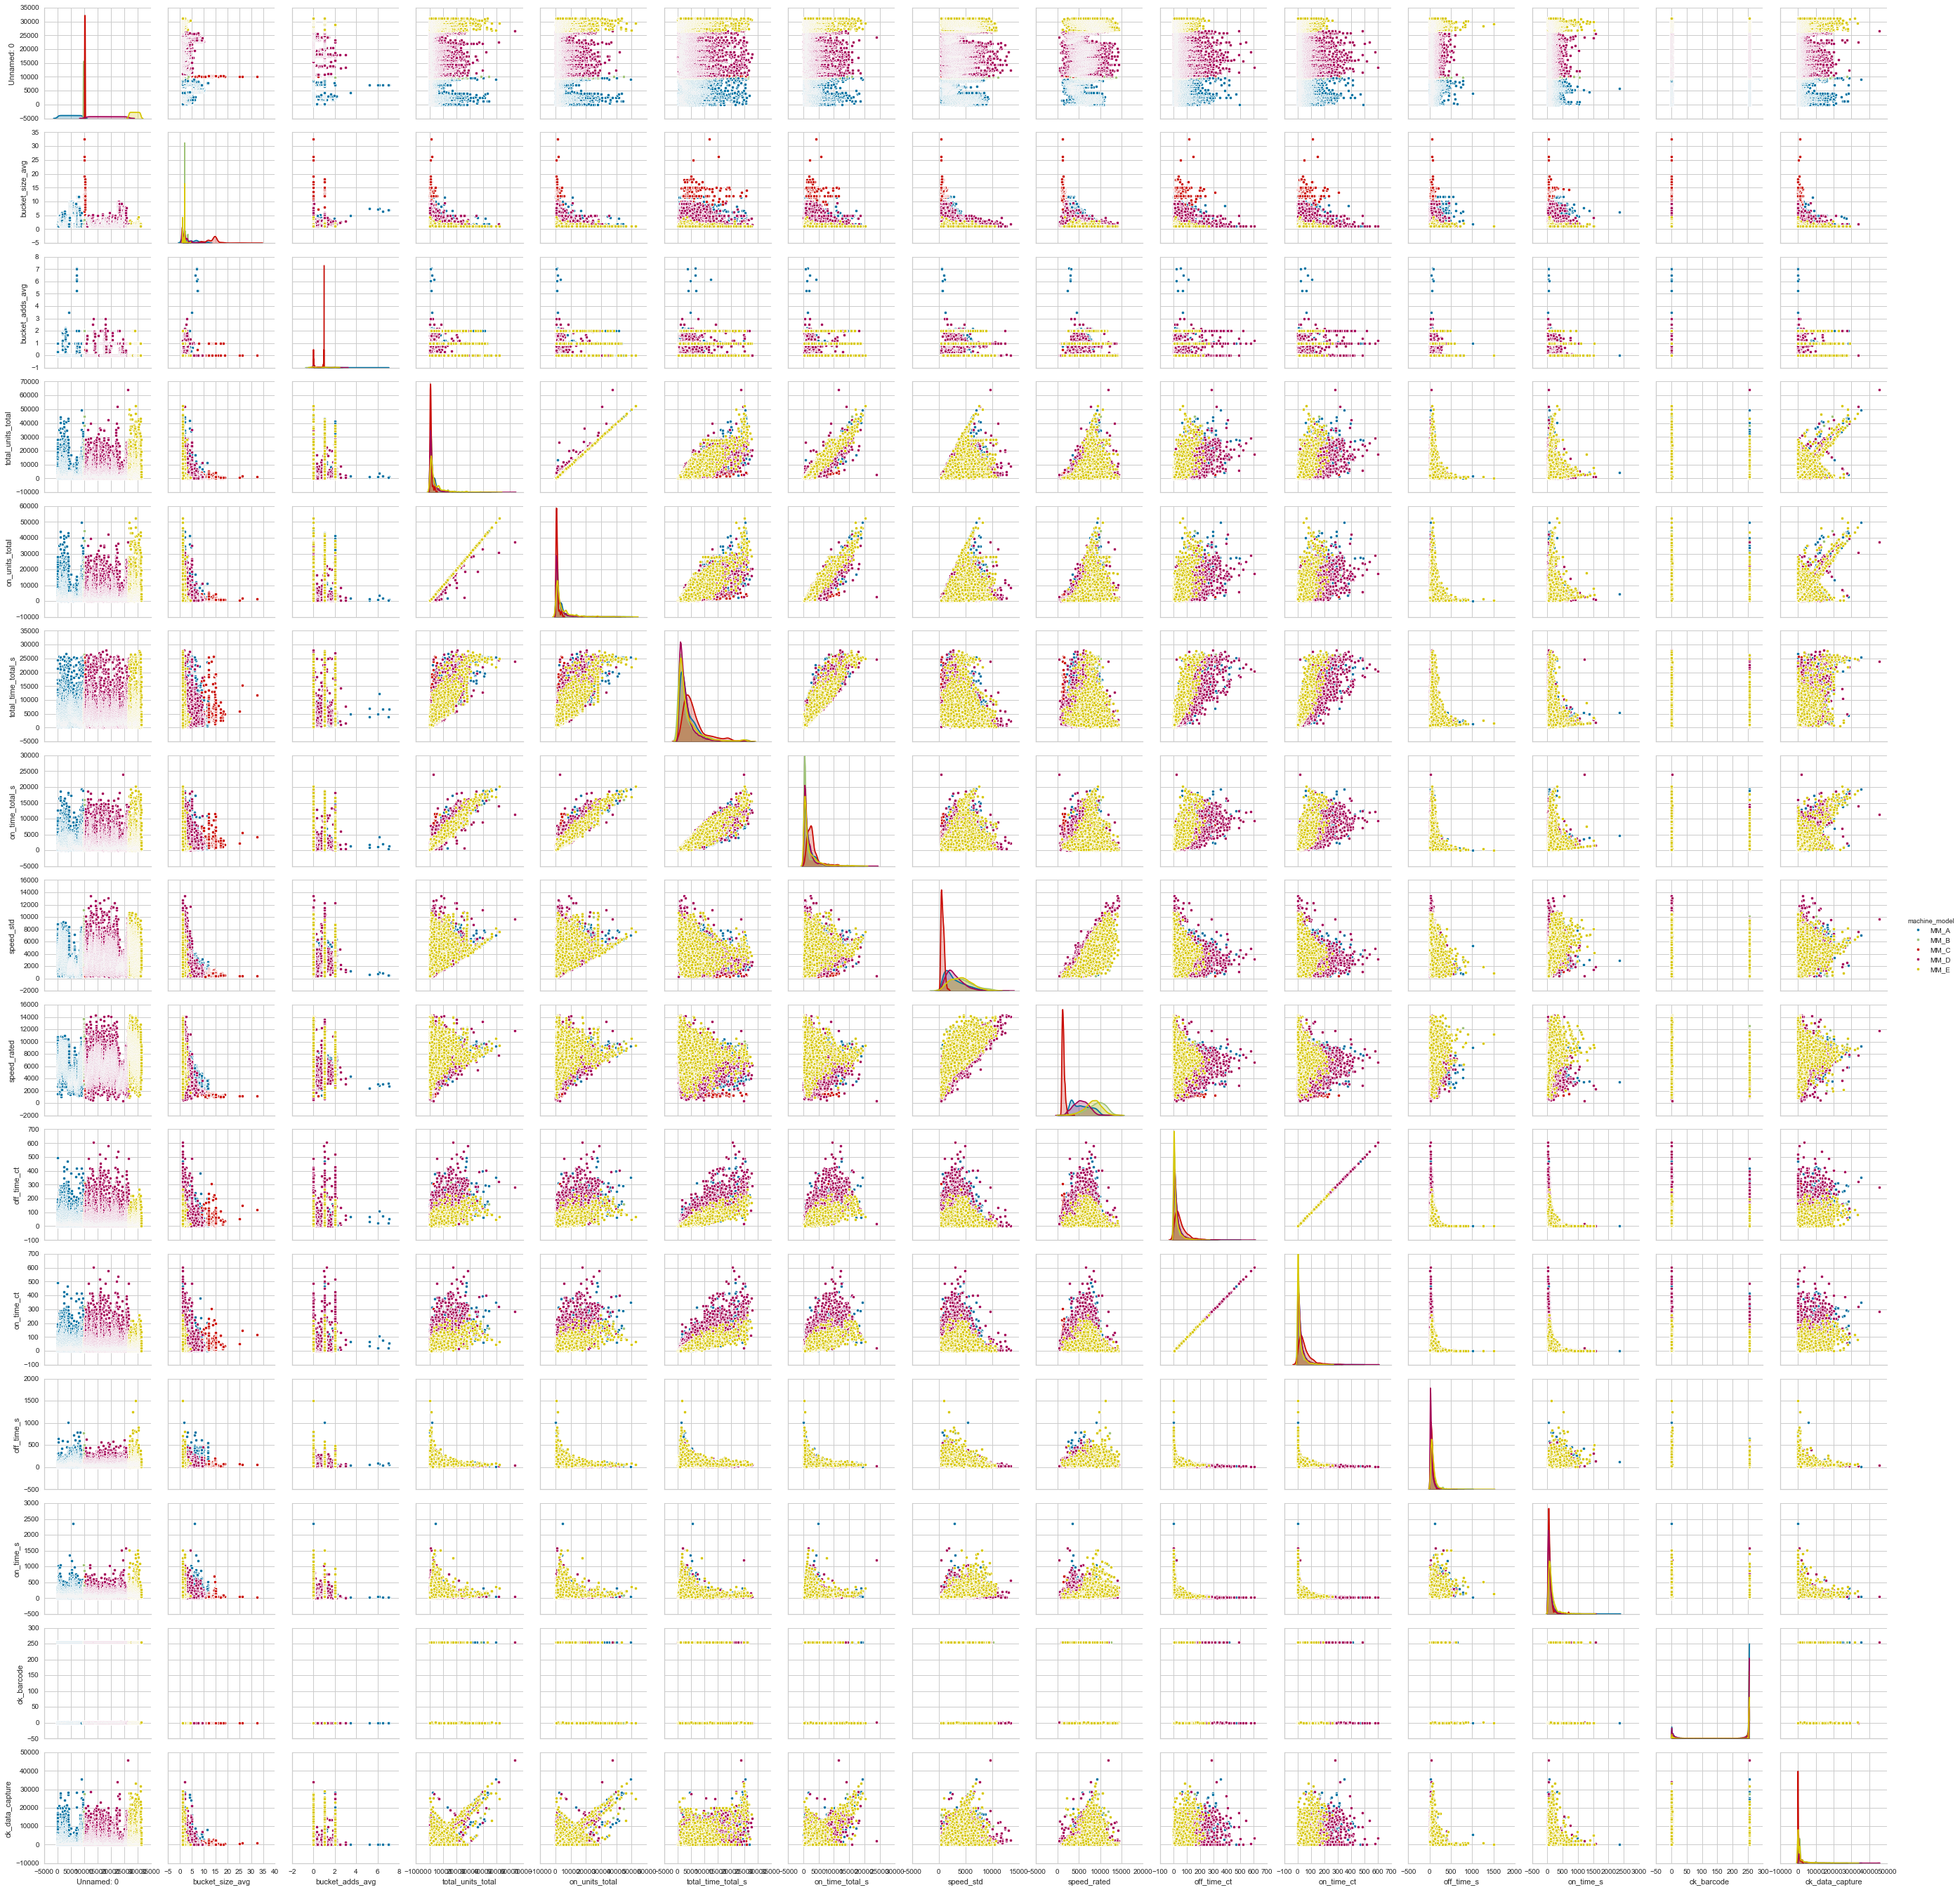

In [8]:
pairplot = sns.pairplot(data, hue='machine_model', height=2.5);

In [9]:
pairplot.savefig("pairplot1.png")

### there are a few trends worth looking into just even in the graphic above. It might be worth sharing this with the folks that oversee the floor for a conversation to see whether we can learn how to make smarter features.

In [10]:
# filing in NAs for bucket_size_avg with mode
mode = data.bucket_size_avg.mode()
data.bucket_size_avg.fillna(mode[0], inplace = True)

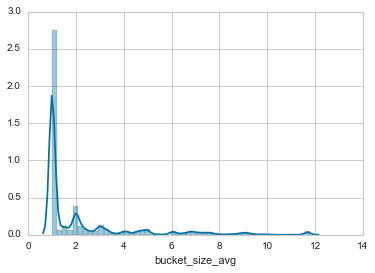

In [21]:
# y axis in 10k increments
ax = sns.distplot(data.bucket_size_avg)

### less than 1% of the dataset is past 12 bucket size, so we will remove. outliers can skew our findings. 

In [22]:
# remove bucket sizes above 
data.drop(data[data.bucket_size_avg >= 12].index, inplace=True)

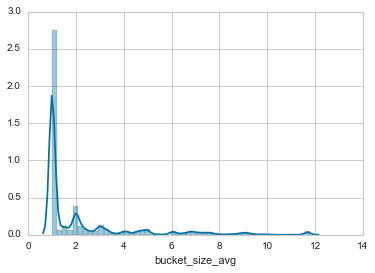

In [23]:
sns.distplot(data.bucket_size_avg)

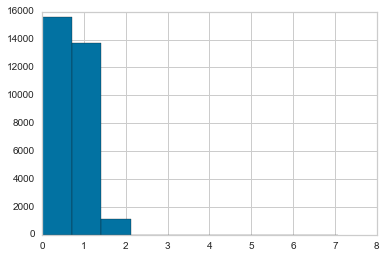

In [24]:
# taking a look at the distro of bucket_adds_avg to also clean inf & high outliers
hist = data.bucket_adds_avg[data.bucket_adds_avg <= 20000].hist(bins=10)

In [25]:
data.drop(data[data.bucket_adds_avg >= 10000].index, inplace=True)

In [26]:
# the vast majority of the dataset has no bucket adds, to see if there's a signal more helpful to binarify
data.bucket_adds_avg.fillna(mode[0], inplace = True)
data['has_bucket_adds'] = np.where(data.bucket_adds_avg>0, 1, 0)

In [27]:
# how does speed differ based on the has_bucket_adds binary? 
# these summary statistics are directionally confusing (median is counterintuitive, 
# distribution is skewed right-- distro is different for 0s & 1s of this binary)
# still, let's keep it in the analysis as we're confident this will be a significant feature.
is_bucket_adds_significant = data[['has_bucket_adds', 'speed_std']].groupby(['has_bucket_adds']).agg(['median', 'mean']).reset_index()
is_bucket_adds_significant

has_bucket_adds    speed_std             
                        median         mean
0               0  2469.524430  2932.126627
1               1  3012.824834  3306.558223

### let's visualize some of our features so far against the outcome variable (speed_std) just to get a teaser...

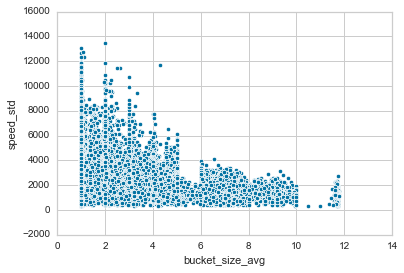

In [28]:
# this is what we expect, yay!
# FOR FUTURE: may be interesting to get this data as a vector [1,2,3] v the aggregated 2.
# this could allow us to come up with more intelligent features around bucket size
sns.scatterplot(y="speed_std", x="bucket_size_avg", data=data)

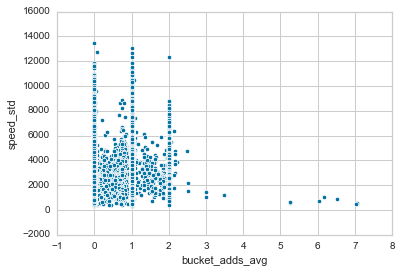

In [29]:
# this looks like what we would expect, but the data for high bucket adds is not populated, so using the binary is best!
sns.scatterplot(y="speed_std", x="bucket_adds_avg", data=data)

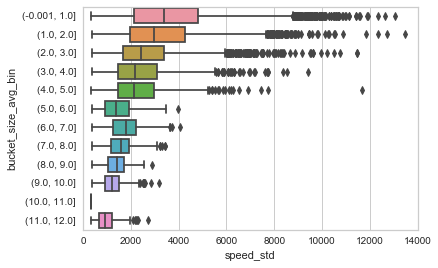

In [30]:
#let's look a little bit more at the speed distribution within all 12 bins
buckets = [0,1,2,3,4,5,6,7,8,9,10,11,12]
data['bucket_size_avg_bin'] = pd.cut(data.bucket_size_avg, buckets, include_lowest=True)
sns.boxplot(y="bucket_size_avg_bin", x="speed_std", data=data)

### outliers are always on the right hand side, we see primary quartiles really close to zero for almost all of the bin sizes, distribution tightens a lot as bin sizes increase and high bucket sizes are contrained at significantly lower speeds for this dataset.

### let's plot the distribution of speed & job size! we know job size is a big predictor of speed :)

In [31]:
data_plotting = data[data.total_units_total <= 10000]

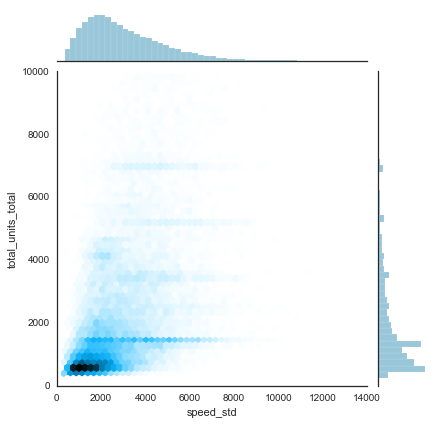

In [32]:
with sns.axes_style('white'):
    sns.jointplot("speed_std", "total_units_total", data_plotting, kind='hex');

    

### the fact that the density view looks like a cone that goes up to the right and up is the relationship we are expecting to see!

we need to figure out a proxy for whether a machine has been able to get "dialed in" and reach its optimal running speed // we started with a binary but have migrated to a discrete numerical variable to still account for incremental shifts

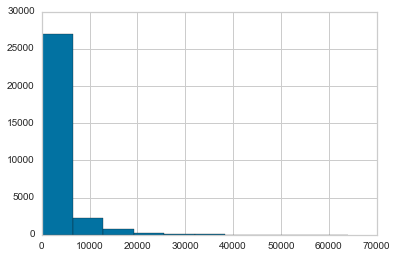

In [33]:
hist = data.total_units_total.hist(bins=10)

In [34]:
buckets = [0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,9000,10000,15000,30000,40000,50000,60000,70000]
data['job_size_bucket'] = pd.cut(data.total_units_total, buckets, include_lowest=True)

In [35]:
## we see a really big pattern below of increasing mean/median speed with job size
job_size_bucket_stats = data[['job_size_bucket', 'speed_std']].groupby(['job_size_bucket']).agg(['count','median', 'mean', 'std']).reset_index()
job_size_bucket_stats

job_size_bucket speed_std                                       
                           count       median         mean          std
0      (-0.001, 500.0]      1979  1440.674789  1595.116473   899.604781
1      (500.0, 1000.0]      6801  1834.164706  2034.806893  1108.652061
2     (1000.0, 1500.0]      5974  2809.800594  3167.527239  1734.231725
3     (1500.0, 2000.0]      2853  2567.058824  2891.923272  1473.873586
4     (2000.0, 2500.0]      2113  3089.418283  3441.354424  1760.585661
5     (2500.0, 3000.0]      1491  3101.311475  3413.676129  1659.732225
6     (3000.0, 3500.0]      1618  3576.352347  3763.262756  1702.676206
7     (3500.0, 4000.0]      1174  3318.755479  3535.811947  1545.768393
8     (4000.0, 4500.0]       996  2847.720844  3319.641471  1641.864886
9     (4500.0, 5000.0]       666  3282.003510  3683.667009  1706.207134
10    (5000.0, 5500.0]       705  4312.281776  4545.305184  1761.017935
11    (5500.0, 6000.0]       437  3741.501320  3924.328632  1411.852708
12    (6000.0, 6500.0]       284  3822.919838  4065.054897  1448.558739
13    (6500.0, 7000.0]       505  4210.398126  4435.482483  1666.343806
14    (7000.0, 7500.0]       352  4177.535076  4356.828551  1537.678615
15    (7500.0, 8000.0]       157  4332.533629  4408.488426  1730.328802
16    (8000.0, 9000.0]       326  4458.128357  4675.274056  1870.710850
17   (9000.0, 10000.0]       243  4524.356436  4775.794406  1594.451750
18  (10000.0, 15000.0]      1053  5019.714599  5130.802527  1726.308407
19  (15000.0, 30000.0]       756  5218.497291  5353.334981  1720.219410
20  (30000.0, 40000.0]        71  5215.899379  5544.645861  1186.488184
21  (40000.0, 50000.0]        24  6282.625695  6468.824660   658.877957
22  (50000.0, 60000.0]         2  7575.532601  7575.532601    27.389927
23  (60000.0, 70000.0]         1  9642.344666  9642.344666          NaN

In [36]:
job_size_bucket_stats['median_delta'] = (job_size_bucket_stats[('speed_std', 'mean')].diff().shift(0))/job_size_bucket_stats[('speed_std', 'mean')]
job_size_bucket_stats

job_size_bucket speed_std                                         \
                           count       median         mean          std   
0      (-0.001, 500.0]      1979  1440.674789  1595.116473   899.604781   
1      (500.0, 1000.0]      6801  1834.164706  2034.806893  1108.652061   
2     (1000.0, 1500.0]      5974  2809.800594  3167.527239  1734.231725   
3     (1500.0, 2000.0]      2853  2567.058824  2891.923272  1473.873586   
4     (2000.0, 2500.0]      2113  3089.418283  3441.354424  1760.585661   
5     (2500.0, 3000.0]      1491  3101.311475  3413.676129  1659.732225   
6     (3000.0, 3500.0]      1618  3576.352347  3763.262756  1702.676206   
7     (3500.0, 4000.0]      1174  3318.755479  3535.811947  1545.768393   
8     (4000.0, 4500.0]       996  2847.720844  3319.641471  1641.864886   
9     (4500.0, 5000.0]       666  3282.003510  3683.667009  1706.207134   
10    (5000.0, 5500.0]       705  4312.281776  4545.305184  1761.017935   
11    (5500.0, 6000.0]       437  3741.501320  3924.328632  1411.852708   
12    (6000.0, 6500.0]       284  3822.919838  4065.054897  1448.558739   
13    (6500.0, 7000.0]       505  4210.398126  4435.482483  1666.343806   
14    (7000.0, 7500.0]       352  4177.535076  4356.828551  1537.678615   
15    (7500.0, 8000.0]       157  4332.533629  4408.488426  1730.328802   
16    (8000.0, 9000.0]       326  4458.128357  4675.274056  1870.710850   
17   (9000.0, 10000.0]       243  4524.356436  4775.794406  1594.451750   
18  (10000.0, 15000.0]      1053  5019.714599  5130.802527  1726.308407   
19  (15000.0, 30000.0]       756  5218.497291  5353.334981  1720.219410   
20  (30000.0, 40000.0]        71  5215.899379  5544.645861  1186.488184   
21  (40000.0, 50000.0]        24  6282.625695  6468.824660   658.877957   
22  (50000.0, 60000.0]         2  7575.532601  7575.532601    27.389927   
23  (60000.0, 70000.0]         1  9642.344666  9642.344666          NaN   

   median_delta  
                 
0           NaN  
1      0.216085  
2      0.357604  
3     -0.095301  
4      0.159655  
5     -0.008108  
6      0.092895  
7     -0.064328  
8     -0.065119  
9      0.098822  
10     0.189567  
11    -0.158238  
12     0.034619  
13     0.083515  
14    -0.018053  
15     0.011718  
16     0.057063  
17     0.021048  
18     0.069192  
19     0.041569  
20     0.034504  
21     0.142867  
22     0.146090  
23     0.214347

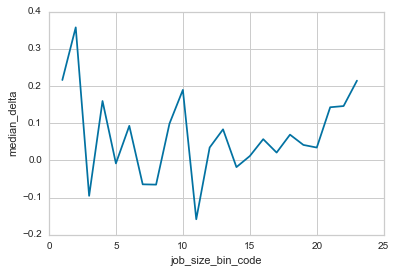

In [37]:
# let's make up a categorical ordered variable that splits up our bins
job_size_bucket_stats['job_size_bin_code'] = job_size_bucket_stats.job_size_bucket.cat.codes
sns.lineplot(x='job_size_bin_code', y='median_delta', data=job_size_bucket_stats)

there are spikes around index 2 (1500), around index 10 (5500), and then in the later 20th index. we should bin up accordingly

In [38]:
buckets = list(range(0, 10000, 1500))
data['job_size_bucket'] = pd.cut(data.total_units_total, buckets, include_lowest=True)
data['job_size_1500_marginal_impact'] = data.job_size_bucket.cat.codes

In [39]:
job_size_bucket_stats['job_size_1500_marginal_impact'] = job_size_bucket_stats.job_size_bucket.cat.codes

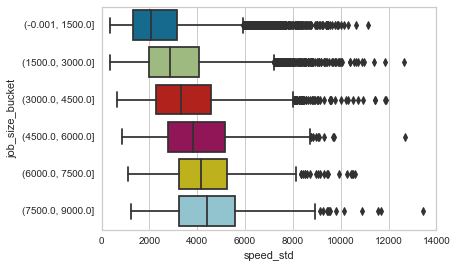

In [40]:
sns.boxplot(y="job_size_bucket", x="speed_std", data=data)

In [41]:
#let's increase the upper bound for the sake of the regression so that all buckets are targetted :)

buckets = list(range(0, 100000, 1500))
data['job_size_bucket'] = pd.cut(data.total_units_total, buckets, include_lowest=True)
data['job_size_1500_marginal_impact'] = data.job_size_bucket.cat.codes

though there is stagnancy in the increase of speed standard, it does seem that really large jobs improve in speed in comparison. for that, it might make sense to try a codified categorical variable instead, "job_size_1500_marginal_impact"

### how does speed differ by machine model & work type?

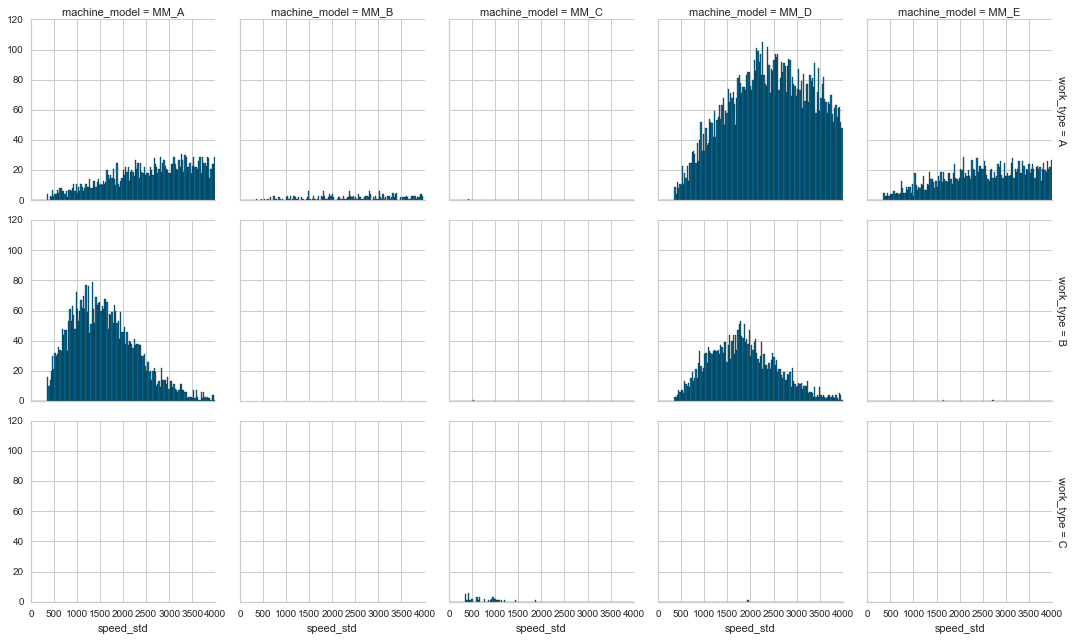

In [42]:
# here we take a look at how work type & machine model is interrelated. 
grid = sns.FacetGrid(data, row="work_type", col="machine_model", margin_titles=True)
grid.map(plt.hist, "speed_std", bins=np.linspace(0, 4000, 150));

# these machines might be meaningfully different. even though we have the hunger for developing generalizable 
# algorythms, it might not be an option and we might have to train & test on machines of their own kind.

## we need to bake time of day/ day of week that the job starts into the relative speed!

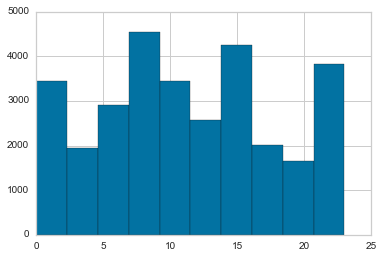

In [43]:
data.work_start_ts = pd.to_datetime(data.work_start_ts)

hist = data.work_start_ts.dt.hour.hist(bins=10)

In [44]:
data['start_off_hours'] = np.where(((data.work_start_ts.dt.hour >= 19) | (data.work_start_ts.dt.hour <= 6)), 1, 0)
data['start_morning'] = np.where(((data.work_start_ts.dt.hour > 6) & (data.work_start_ts.dt.hour < 12)), 1, 0)
data['start_afternoon'] = np.where(((data.work_start_ts.dt.hour >= 12) & (data.work_start_ts.dt.hour < 19)), 1, 0)

In [45]:
# monday is 0 index

data['day_of_week'] = data.work_start_ts.dt.dayofweek

## machine reliability effect

### we need a proxy for how functional the machine was for the duration of the job. since we do not have access to this variable before a job runs, we will have to try to impute it using the variables we do have

In [46]:
data['perc_job_machine_off'] = (data.total_time_total_s - data.on_time_total_s)/data.total_time_total_s

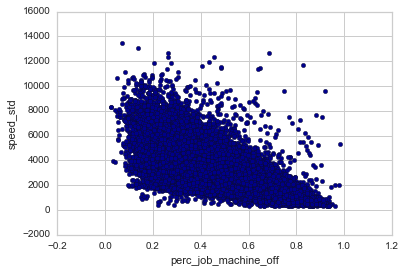

In [47]:
# this is what we expect, yay!
ax2 = data.plot.scatter(x='perc_job_machine_off', y='speed_std', c='DarkBlue')

In [48]:
buckets = [0,.10,.2,.3,.4,.5,.6,.7,.8,.9,1]
data['percentage_job_off_bucket'] = pd.cut(data.perc_job_machine_off, buckets, include_lowest=True)

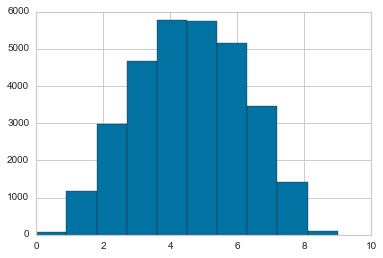

In [49]:
data['per_off_code'] = data.percentage_job_off_bucket.cat.codes
hist = data.per_off_code.hist(bins=10)

### it's a bit surprising that this is a pseudo-normal distribution with mean around 50%. this dataset should be questioned... if most plants are supposed to be running 24/7, why is this sample set skewed? 

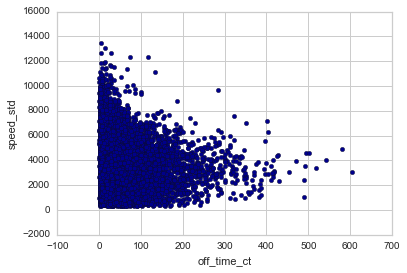

In [50]:
# what about the count of offs?
ax2 = data.plot.scatter(x='off_time_ct', y='speed_std', c='DarkBlue')

In [51]:
# quite wild distribution, maybe it will make more sense to bin it to understand it
buckets = [0, 10,20,30,50,100,200,300,700]
data['job_stops_freq_bucket'] = pd.cut(data.off_time_ct, buckets, include_lowest=True)

In [52]:
job_stops_freq_bucket_stats = data[['job_stops_freq_bucket', 'speed_std']].groupby(['job_stops_freq_bucket']).agg(['count','median', 'mean', 'std']).reset_index()
job_stops_freq_bucket_stats

job_stops_freq_bucket speed_std                                       
                            count       median         mean          std
0        (-0.001, 10.0]     10433  3019.372609  3416.505327  1885.344111
1          (10.0, 20.0]      7333  2611.124260  2997.341402  1716.980974
2          (20.0, 30.0]      4067  2541.087866  2921.020625  1729.882820
3          (30.0, 50.0]      4028  2556.516796  2894.953924  1711.819792
4         (50.0, 100.0]      3115  2697.917355  3018.161160  1784.992663
5        (100.0, 200.0]      1248  3052.621115  3235.312738  1754.451482
6        (200.0, 300.0]       257  3203.954841  3265.243462  1433.681809
7        (300.0, 700.0]       100  3240.495825  3347.338594  1370.282398

In [53]:
job_stops_freq_bucket_stats['mean_delta'] = (job_stops_freq_bucket_stats[('speed_std', 'mean')].diff().shift(0))/job_stops_freq_bucket_stats[('speed_std', 'mean')]
job_stops_freq_bucket_stats
# curious... the frequency of the stops don't seem to descriptively have such a clear interaction with speed 
# well, compared ... to other vars we have seen associated with stops (% time off...)
# let's come back to this later, but maybe it's better to predict avg-time-off ...

job_stops_freq_bucket speed_std                                         \
                            count       median         mean          std   
0        (-0.001, 10.0]     10433  3019.372609  3416.505327  1885.344111   
1          (10.0, 20.0]      7333  2611.124260  2997.341402  1716.980974   
2          (20.0, 30.0]      4067  2541.087866  2921.020625  1729.882820   
3          (30.0, 50.0]      4028  2556.516796  2894.953924  1711.819792   
4         (50.0, 100.0]      3115  2697.917355  3018.161160  1784.992663   
5        (100.0, 200.0]      1248  3052.621115  3235.312738  1754.451482   
6        (200.0, 300.0]       257  3203.954841  3265.243462  1433.681809   
7        (300.0, 700.0]       100  3240.495825  3347.338594  1370.282398   

  mean_delta  
              
0        NaN  
1  -0.139845  
2  -0.026128  
3  -0.009004  
4   0.040822  
5   0.067119  
6   0.009166  
7   0.024525

In [56]:
data['job_stops_freq_code'] = data.job_stops_freq_bucket.cat.codes
# keep this here for reference, though we cannot use it in the model. just here for record keeping 
# in case we decide to do other analysis using this notebook

## The human effect
### we now need some sort of proxy for how individual workers impact speed outcomes. we won't be using this in our model due to the business case at hand, but we'll maintain this here for now so that we can use this in the future if needed.

all dummie variables are included, and then the first one on the list is excluded when running the model for coefficient interpretability. For example, for employees, employee P001 will be excluded when running the model. That means the coefficient on P002 is the marginal effect on speed of P002 overseeing the work as opposed to P001 overseeing the work.

In [57]:
# humanIdDummies = pd.get_dummies(data.humanId)

In [58]:
# data = data.join(humanIdDummies)

## The machine type effect
### we now need a way to differentiate between machine types. let's binarify!

In [59]:
machineModelDummies = pd.get_dummies(data.machine_model)

In [60]:
data = data.join(machineModelDummies)

## The envelope effect
### we need to drop the relative 

In [61]:
# we will drop data that is not filled in, as this is a crucial predictor
data.drop(data[data.work_type.isnull()].index, inplace=True)

In [62]:
envelopeDummies = pd.get_dummies(data.work_type)

In [63]:
data = data.join(envelopeDummies)

## should we add the workid dummies?

In [64]:
dataCopy = data[['workId', 'bucket_size_avg','has_bucket_adds', 'job_stops_freq_code',
       'job_size_1500_marginal_impact', 'perc_job_machine_off', 'MM_A', 'MM_B', 'MM_C',
       'MM_D', 'MM_E', 'A', 'B', 'C', 'day_of_week', 'start_off_hours', 'start_morning', 'start_afternoon', 'speed_std']]

In [65]:
dataCopy.drop(dataCopy[dataCopy.workId.isnull()].index, inplace=True)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [66]:
workIdDummies = pd.get_dummies(dataCopy.workId)

In [67]:
dataCopy = dataCopy.join(workIdDummies)

In [68]:
del dataCopy['workId']

In [69]:
# here we see the strongest correlation between features built so far & the outcome variable, speed_std
dataCopy.corr()['speed_std'].sort_values()

perc_job_machine_off            -0.714210
B                               -0.447050
bucket_size_avg                 -0.372360
W0200                           -0.143839
W0201                           -0.129468
                                   ...   
W0044                            0.244616
MM_E                             0.246968
job_size_1500_marginal_impact    0.415966
A                                0.450791
speed_std                        1.000000
Name: speed_std, Length: 349, dtype: float64

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> variable selection

### lets visualize multicollinearity as this could impact coefficient accuracy. coefficient accuracy is not a focus in the first pass of this project, so we are including all variables that make sense for our business case. We are, however, still taking a look so that we better understand our dataset

let's interpret coefficients of features that are collinear with another feature with a grain of salt

In [70]:
yvar = 'speed_std'

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

Xvars=['bucket_size_avg','has_bucket_adds', 'job_stops_freq_code',
       'job_size_1500_marginal_impact', 'perc_job_machine_off', 'MM_A', 'MM_B', 'MM_C',
       'MM_D', 'MM_E', 'A', 'B', 'C', 'day_of_week', 'start_off_hours', 'start_morning', 'start_afternoon']

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

to_be_correlated = data[Xvars]
corr = to_be_correlated.corr()
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

### benchmarks

MAE & RMSE are often used to gage effectiveness of a prediction.
- Mean Absolute Error (MAE): The average of the absolute value of the differences between the predictions and true values.
- Root Mean Squared Error (RMSE): The square root of the average of the squared differences between the predictions and true values.

How do we know if our model is good enough? one option is to come up with naive benchmarks using our dataset (always guess that speed will be the median, for example). And then compare the benchmark to our models MAE & RMSE.

In [71]:
# Calculate mae and rmse
def evaluate_predictions(predictions, true):
    mae = np.mean(abs(predictions - true))
    rmse = np.sqrt(np.mean((predictions - true) ** 2))
    
    return mae, rmse

In [81]:
# the naive baseline is the median
# let's remove C models as we see that they are highly skewing our dataset
# and they are not a meaningful part of the sample (note that removing C jobs is not huring )
linReg = dataCopy[dataCopy.MM_C==0]

Xvars = linReg.columns.to_list()
Xvars = [x for x in Xvars if x != 'speed_std']
yvar = 'speed_std'

# let's take all other machines together & have a look at which models perform best according to MAE/RMSE
X_all = linReg[Xvars]
X_all = sm.add_constant(X_all)

y_all = linReg[yvar]

train_features, test_features, train_labels, test_labels = train_test_split(X_all, y_all, test_size = 0.25, random_state = 42)

median_pred = train_labels.median()
median_preds = [median_pred for _ in range(len(test_features))]
true = test_labels

# display the naive baseline metrics
mb_mae, mb_rmse = evaluate_predictions(median_preds, true)
print('Median Baseline  MAE: {:.4f}'.format(mb_mae))
print('Median Baseline RMSE: {:.4f}'.format(mb_rmse))

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Median Baseline  MAE: 1407.5427
Median Baseline RMSE: 1844.4676


In [82]:
# evaluate often-used ML models for continuous problems
def evaluate(X_train, X_test, y_train, y_test):
    # Names of models
    model_name_list = ['Linear Regression', 'ElasticNet Regression',
                      'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted', 'Baseline']
    
    # instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(X_train)
    test_scaled = scaler.transform(X_test)
    
    # dataframe for results
    results = pd.DataFrame(columns=['mae', 'rmse'], index = model_name_list)
    
    # train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6]):
        model.fit(train_scaled, y_train)
        predictions = model.predict(test_scaled)
        
        # metrics
        mae = np.mean(abs(predictions - y_test))
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        
        # insert results into the dataframe
        model_name = model_name_list[i]
        results.ix[model_name, :] = [mae, rmse]
    
    # median Value Baseline Metrics
    baseline = np.median(y_train)
    baseline_mae = np.mean(abs(baseline - y_test))
    baseline_rmse = np.sqrt(np.mean((baseline - y_test) ** 2))
    
    results.ix['Baseline', :] = [baseline_mae, baseline_rmse]
    
    return results

In [83]:
results = evaluate(train_features, test_features, train_labels, test_labels)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 
.ix is deprecated. Please us

In [ ]:
results

looks like a tree based model is going to be a good place to start. 
linear regression has some really wild outliers in the average error that are terribly skewing our MAE :( 
--generally standardized (re-scaled features) MAE / RMSE measurements are a good comparison but here it seems to be really borking the linear MAE/RMSE!

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> linear regressions


### regular linear regression, full variable dump (with exclusion of strongly collinear) on first pass of the model

In [77]:
model = sm.OLS(y_all, X_all).fit()
predictions_all = model.predict(X_all) # make the predictions by the model

# Print out the statistics
model.summary()

# see that an 80% R squared is not bad at all for the prediction of a continuous variable. 
# given all the information that we have, however (we would expect this to be higher. This is motivation 
# to split up our modeling by machine model, since distribution above showed such immense skew)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_std   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     324.9
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:15:20   Log-Likelihood:            -2.2902e+05
No. Observations:               28201   AIC:                         4.587e+05
Df Residuals:                   27867   BIC:                         4.615e+05
Df Model:                         333                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                          3387.6194     85.253     39.736      0.000    3220.520    3554.719
bucket_size_avg                 -36.0192      5.797     -6.213      0.000     -47.382     -24.656
has_bucket_adds                  33.8566     17.970      1.884      0.060      -1.365      69.078
job_stops_freq_code            -115.8573      4.420    -26.212      0.000    -124.521    -107.194
job_size_1500_marginal_impact   106.6697      2.607     40.916      0.000     101.560     111.780
perc_job_machine_off          -6253.7288     34.985   -178.756      0.000   -6322.300   -6185.157
MM_A                            963.2647     24.927     38.643      0.000     914.406    1012.123
MM_B                           1128.2123     37.203     30.326      0.000    1055.293    1201.131
MM_C                            -1.6e-11   2.56e-11     -0.624      0.533   -6.63e-11    3.43e-11
MM_D                            363.9985     23.984     15.177      0.000     316.990     411.007
MM_E                            932.1439     25.724     36.237      0.000     881.724     982.564
A                              1491.4844    132.517     11.255      0.000    1231.744    1751.225
B                               405.9833    133.921      3.032      0.002     143.492     668.474
C                              1490.1518    343.868      4.333      0.000     816.153    2164.150
day_of_week                      -4.0506      3.243     -1.249      0.212     -10.408       2.306
start_off_hours                 986.9206     29.171     33.832      0.000     929.744    1044.097
start_morning                  1200.4477     29.415     40.810      0.000    1142.793    1258.103
start_afternoon                1200.2511     29.488     40.704      0.000    1142.454    1258.048
W0001                           -25.7153    815.995     -0.032      0.975   -1625.106    1573.675
W0002                           640.8007     82.168      7.799      0.000     479.747     801.855
W0003                          1135.7589     58.681     19.355      0.000    1020.741    1250.776
W0004                          2590.5761    408.420      6.343      0.000    1790.052    3391.100
W0005                           986.3067     64.236     15.354      0.000     860.400    1112.213
W0006                            95.9407    211.784      0.453      0.651    -319.167     511.049
W0007                          -205.1642    175.297     -1.170      0.242    -548.754     138.426
W0008                          -387.3525     79.321     -4.883      0.000    -542.826    -231.879
W0009                          -131.6056     99.282     -1.326      0.185    -326.204      62.992
W0010                            -1.6263    164.636     -0.010      0.992    -324.320     321.068
W0011                            85.0445    1

In [84]:
# so above when we scaled the variables we ended up with super wonk MAE / RMSE for the linear model...
# let's see if they look better unscaled...
deltas = abs(predictions_all - y_all)
mae = np.mean(deltas)

In [79]:
deltas.describe()

count    2.820100e+04
mean     5.591579e+02
std      5.915026e+02
min      2.273737e-13
25%      1.929253e+02
50%      4.170978e+02
75%      7.456791e+02
max      1.074185e+04
dtype: float64

In [80]:
mae

559.1579030219184

yeap, they do... cool well good to know it's still worst than tree based approaches! :|

In [60]:
# let's do this exercise for machine A,D,E, for which we have the most data points (see histogram above)

In [85]:
linReg = dataCopy[dataCopy.MM_D==1]

Xvars = linReg.columns.to_list()
Xvars = [x for x in Xvars if x != 'speed_std']
yvar = 'speed_std'

X_d = linReg[Xvars]
X_d = sm.add_constant(X_d)

y_d = linReg[yvar]
# Note the difference in argument order
model = sm.OLS(y_d, X_d).fit()
predictions_d = model.predict(X_d) # make the predictions by the model

# Print out the statistics
model.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_std   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     133.9
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:24:50   Log-Likelihood:            -1.2068e+05
No. Observations:               14814   AIC:                         2.419e+05
Df Residuals:                   14522   BIC:                         2.442e+05
Df Model:                         291                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bucket_size_avg                 -99.7651     12.012     -8.305      0.000    -123.311     -76.219
has_bucket_adds                  -3.0763     25.026     -0.123      0.902     -52.130      45.977
job_stops_freq_code            -117.3079      6.289    -18.651      0.000    -129.636    -104.980
job_size_1500_marginal_impact   154.1855      4.427     34.826      0.000     145.507     162.864
perc_job_machine_off          -5559.7568     48.917   -113.656      0.000   -5655.641   -5463.872
MM_A                          -4.406e-11    4.5e-12     -9.790      0.000   -5.29e-11   -3.52e-11
MM_B                            4.56e-12   2.61e-12      1.749      0.080   -5.49e-13    9.67e-12
MM_C                            -6.6e-12   1.78e-12     -3.711      0.000   -1.01e-11   -3.11e-12
MM_D                           3455.7011    102.663     33.661      0.000    3254.469    3656.933
MM_E                          -2.554e-11   3.55e-12     -7.204      0.000   -3.25e-11   -1.86e-11
A                              1508.4735    132.316     11.401      0.000    1249.118    1767.829
B                               571.3965    135.772      4.208      0.000     305.266     837.528
C                              1375.8311    356.712      3.857      0.000     676.630    2075.032
day_of_week                      -4.4263      4.632     -0.956      0.339     -13.506       4.653
start_off_hours                1003.3842     35.538     28.234      0.000     933.725    1073.043
start_morning                  1260.1801     35.880     35.122      0.000    1189.851    1330.510
start_afternoon                1192.1368     35.961     33.151      0.000    1121.649    1262.624
W0001                          4.126e-13   1.03e-12      0.402      0.688    -1.6e-12    2.43e-12
W0002                           766.2808    129.269      5.928      0.000     512.898    1019.664
W0003                           716.1503    113.048      6.335      0.000     494.563     937.738
W0004                          4086.8756    594.443      6.875      0.000    2921.691    5252.060
W0005                           766.4375    135.939      5.638      0.000     499.980    1032.895
W0006                            50.1682    343.829      0.146      0.884    -623.780     724.116
W0007                          -247.8497    194.366     -1.275      0.202    -628.832     133.132
W0008                          -380.2859     86.095     -4.417      0.000    -549.044    -211.528
W0009                             7.4334    132.020      0.056      0.955    -251.343     266.210
W0010                            -5.6794    205.273     -0.028      0.978    -408.040     396.682
W0011                           111.0978    146.298      0.759      0.448    -175.665     397.860
W0012                           541.4226     

In [86]:
linReg = dataCopy[dataCopy.MM_E==1]

Xvars = linReg.columns.to_list()
Xvars = [x for x in Xvars if x != 'speed_std']
yvar = 'speed_std'

X_e = linReg[Xvars]
X_e = sm.add_constant(X_e)

y_e = linReg[yvar]
# Note the difference in argument order
model = sm.OLS(y_e, X_e).fit()
predictions_e = model.predict(X_e) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_std   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     231.1
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:24:52   Log-Likelihood:                -34609.
No. Observations:                4350   AIC:                         6.948e+04
Df Residuals:                    4221   BIC:                         7.030e+04
Df Model:                         128                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bucket_size_avg                -535.0414     70.243     -7.617      0.000    -672.755    -397.327
has_bucket_adds                 213.6325     40.388      5.290      0.000     134.451     292.814
job_stops_freq_code            -322.0162     11.753    -27.399      0.000    -345.058    -298.975
job_size_1500_marginal_impact    73.0344      4.331     16.865      0.000      64.544      81.525
perc_job_machine_off          -9303.0951     80.320   -115.826      0.000   -9460.564   -9145.627
MM_A                           1.741e-12   2.63e-12      0.662      0.508   -3.41e-12    6.89e-12
MM_B                           2.347e-12   1.85e-12      1.266      0.206   -1.29e-12    5.98e-12
MM_C                           7.995e-12   2.24e-12      3.575      0.000    3.61e-12    1.24e-11
MM_D                           5.679e-12   3.44e-12      1.651      0.099   -1.06e-12    1.24e-11
MM_E                           4871.9905     77.242     63.074      0.000    4720.555    5023.426
A                              3021.9655     89.425     33.793      0.000    2846.645    3197.286
B                              1850.0250    137.025     13.501      0.000    1581.385    2118.665
C                              9.659e-12   1.64e-12      5.906      0.000    6.45e-12    1.29e-11
day_of_week                      -4.9125      6.929     -0.709      0.478     -18.497       8.672
start_off_hours                1467.6954     29.484     49.779      0.000    1409.891    1525.500
start_morning                  1704.9765     31.642     53.883      0.000    1642.941    1767.012
start_afternoon                1699.3186     31.105     54.631      0.000    1638.336    1760.301
W0001                         -8.419e-13   1.27e-12     -0.660      0.509   -3.34e-12    1.66e-12
W0002                           -43.4381    128.280     -0.339      0.735    -294.934     208.058
W0003                           750.4804     81.973      9.155      0.000     589.770     911.191
W0004                           275.1835    696.691      0.395      0.693   -1090.698    1641.065
W0005                           728.3720     86.794      8.392      0.000     558.210     898.534
W0006                          -281.5931    351.020     -0.802      0.422    -969.777     406.591
W0007                          8.317e-13    1.8e-12      0.461      0.645    -2.7e-12    4.37e-12
W0008                          3.023e-12   1.13e-12      2.677      0.007    8.09e-13    5.24e-12
W0009                          -531.6670    179.866     -2.956      0.003    -884.300    -179.034
W0010                         -1006.3487    314.643     -3.198      0.001   -1623.215    -389.482
W0011                          -398.5634    696.595     -0.572      0.567   -1764.256     967.130
W0012                          -176.2646    6

In [87]:
linReg = dataCopy[dataCopy.MM_A==1]

Xvars = linReg.columns.to_list()
Xvars = [x for x in Xvars if x != 'speed_std']
yvar = 'speed_std'

X_a = linReg[Xvars]
X_a = sm.add_constant(X_a)

y_a = linReg[yvar]
# Note the difference in argument order
model = sm.OLS(y_a, X_a).fit()
predictions_a = model.predict(X_a) # make the predictions by the model

# Print out the statistics
model.summary()

# now that's more like it! 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_std   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     240.4
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:24:53   Log-Likelihood:                -67018.
No. Observations:                8564   AIC:                         1.346e+05
Df Residuals:                    8292   BIC:                         1.365e+05
Df Model:                         271                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bucket_size_avg                  -0.1539      5.819     -0.026      0.979     -11.560      11.253
has_bucket_adds                 109.5659     27.110      4.042      0.000      56.424     162.708
job_stops_freq_code             -62.5033      6.046    -10.339      0.000     -74.354     -50.652
job_size_1500_marginal_impact    93.8110      3.850     24.368      0.000      86.264     101.358
perc_job_machine_off          -5785.7962     51.855   -111.576      0.000   -5887.446   -5684.147
MM_A                           3168.4818     25.753    123.036      0.000    3118.000    3218.963
MM_B                          -1.099e-11   1.78e-12     -6.171      0.000   -1.45e-11    -7.5e-12
MM_C                           7.822e-12   1.25e-12      6.236      0.000    5.36e-12    1.03e-11
MM_D                          -7.972e-12   1.54e-12     -5.176      0.000    -1.1e-11   -4.95e-12
MM_E                           6.996e-12   1.15e-12      6.086      0.000    4.74e-12    9.25e-12
A                              2194.6372     23.542     93.221      0.000    2148.489    2240.786
B                               973.8446     30.373     32.063      0.000     914.307    1033.383
C                              1.833e-12   1.82e-12      1.009      0.313   -1.73e-12     5.4e-12
day_of_week                      -9.0893      4.528     -2.007      0.045     -17.965      -0.214
start_off_hours                 948.5759     12.721     74.565      0.000     923.639     973.513
start_morning                   999.2099     13.517     73.924      0.000     972.714    1025.706
start_afternoon                1220.6960     14.007     87.149      0.000    1193.239    1248.153
W0001                           139.0270    613.552      0.227      0.821   -1063.688    1341.742
W0002                          1182.9574    126.935      9.319      0.000     934.134    1431.781
W0003                          1662.3276     89.708     18.530      0.000    1486.477    1838.178
W0004                          1706.6744    613.782      2.781      0.005     503.508    2909.841
W0005                          1338.4022    101.769     13.151      0.000    1138.910    1537.894
W0006                           417.3519    275.446      1.515      0.130    -122.591     957.295
W0007                          -704.5312    354.997     -1.985      0.047   -1400.414      -8.648
W0008                          -721.6982    186.871     -3.862      0.000   -1088.012    -355.385
W0009                          -203.5951    187.226     -1.087      0.277    -570.604     163.414
W0010                          -208.4592    434.087     -0.480      0.631   -1059.379     642.461
W0011                          -268.0259    218.477     -1.227      0.220    -696.296     160.244
W0012                           496.8213     

thus for machine A/E we are able to get to an accuracy close to 90% in predicting speed standard, but not for machine D. there seems to be a lot of unmeasurables by our dataset that are accounting for variance in that data set.

let us follow this machine-exclusive, taking machine A as an example (X_a, y_a, predictions_a) and comparing it to the model trained by all data points (X_all, y_all, predictions_all) to see how far we can take this model

### Ridge variable tuning method

& a plot of residuals

Residuals, in the context of regression models, are the difference between the observed value of the target variable (y) and the predicted value (ŷ), i.e. the error of the prediction. The residuals plot shows the difference between residuals on the vertical axis and the dependent variable on the horizontal axis, allowing you to detect regions within the target that may be susceptible to more or less error.

Ridge Regression is a technique used when the data suffers from multicollinearity ( independent variables are highly correlated). In multicollinearity, even though the least squares estimates (OLS) are unbiased, their variances are large which deviates the observed value far from the true value. By adding a degree of bias to the regression estimates, ridge regression reduces the standard errors.

In a linear equation, prediction errors can be decomposed into two sub components. First is due to the biased and second is due to the variance. Prediction error can occur due to any one of these two or both components. Here, we’ll discuss about the error caused due to variance.

In [88]:
# split the data into training and testing sets || EXAMPLES BELOW ARE FOR MACHINE A
train_features, test_features, train_labels, test_labels = train_test_split(X_a, y_a, test_size = 0.25, random_state = 42)

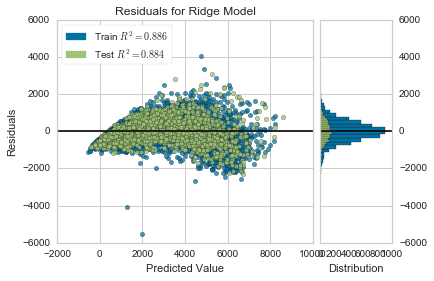

In [89]:
ridge = Ridge()
visualizer = ResidualsPlot(ridge)

visualizer.fit(train_features, train_labels)  # fit the training data to the visualizer
visualizer.score(test_features, test_labels)  # evaluate the model on the test data
visualizer.show()                             # finalize and render the figure

A common use of the residuals plot is to analyze the variance of the error of the regressor. If the points are randomly dispersed around the horizontal axis, a linear regression model is usually appropriate for the data; otherwise, a non-linear model is more appropriate. In the case above, we see a somewhat funnel-linear distribution of residuals against the target in two dimensions. This seems to indicate that a linear model is not the best choice. We can see, however, from the histogram that our error is normally distributed around zero, which generally indicates a well fitted model.

from: https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

### Lasso tuning, variable selection & regressing

A prediction error plot shows the actual targets from the dataset against the predicted values generated by our model. This allows us to see how much variance is in the model. We can diagnose regression models using this plot by comparing against the 45 degree line, where the prediction exactly matches the model.

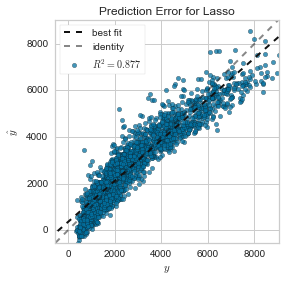

In [90]:
# instantiate the linear model and visualizer
lasso = Lasso()
visualizer = PredictionError(lasso)

visualizer.fit(train_features, train_labels)  # Fit the training data to the visualizer
visualizer.score(test_features, test_labels)  # Evaluate the model on the test data
visualizer.show()                             # Finalize and render the figure

## since fancier algorythms add complexity and decrease or only slightly increase accuracy of the fit, so far we should go with straight up linear model with "naive" manual variable choice

### Random forest 
Random forest is a black-box machine learning algorythm that allows you to build predictors without much human influence over the variables. (https://towardsdatascience.com/random-forest-3a55c3aca46d) This is helpful when getting relative weight of features in predicting your outcome variable. it's less useful in using it as the predictive algorythm itself in our case, as it's predictability is lower than that of the linear regression

In [91]:
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# train the model on training data
rf.fit(train_features, train_labels);

# use the predict method on the test data
predictions = rf.predict(test_features)
# calculate the absolute errors
errors = abs(predictions - test_labels)
print('mean absolute error: or how far we are on average from the real value', round(np.mean(errors), 2), '.')

# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# display accuracy
accuracy = 100 - np.mean(mape)
print('accuracy:', round(accuracy, 2), '%.')

# good to know that the accuracy of predictions is quite close to what we are getting with a linear model
# calculate & visualize permutation importance of variables

def r2(rf, train_features, train_labels):
    return r2_score(train_labels, rf.predict(train_features))

perm_imp_rfpimp = permutation_importances(rf, train_features, train_labels, r2)

# relative importance of the features in predicting target, sorted descending.
perm_imp_rfpimp

mean absolute error: or how far we are on average from the real value 343.13 .
accuracy: 85.62 %.


Importance
Feature                                    
perc_job_machine_off           8.916477e-01
A                              2.213249e-01
bucket_size_avg                1.549091e-01
B                              6.420156e-02
job_size_1500_marginal_impact  4.730901e-02
...                                     ...
W0149                         -3.339750e-09
W0084                         -3.473537e-09
W0067                         -3.529916e-09
W0127                         -3.423999e-08
W0137                         -1.014333e-07

[348 rows x 1 columns]

# Phase 2

### this model is meant to solve a very particular business use case. Given the information that we get from barcode scans, how can we predict that job speed? thus, we must impute or exclude variables that are not available to us before a job ever runs.

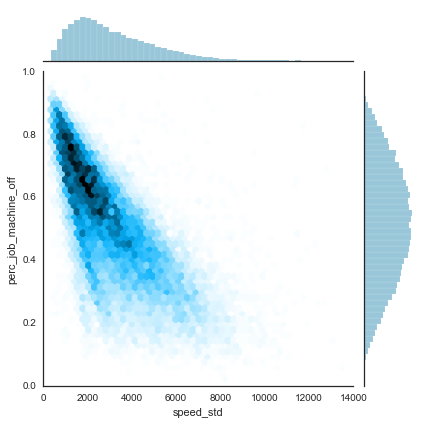

In [92]:
# reasoning behind wanting to predict perc_job_machine_off for the sake of showing 

with sns.axes_style('white'):
    sns.jointplot("speed_std", "perc_job_machine_off", data, kind='hex');

In [93]:
pairplot = sns.pairplot(data[['machine_model', 'work_type', 'bucket_size_avg', 'bucket_adds_avg',
       'total_units_total', 'on_units_total', 'total_time_total_s',
       'on_time_total_s', 'speed_std', 'speed_rated', 'off_time_ct',
       'on_time_ct', 'off_time_s', 'on_time_s', 'has_bucket_adds', 'bucket_size_avg_bin',
       'job_size_bucket',
       'job_size_1500_marginal_impact', 'MM_A', 'MM_B', 'MM_C',
       'MM_D', 'MM_E', 'A', 'B', 'C']], hue='work_type', height=2.5);
pairplot.savefig("percent_time_off.png")

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x118e42440> (for post_execute):
Error in callback <function flush_figures at 0x118e4b830> (for post_execute):



KeyboardInterrupt



KeyboardInterrupt: 

In [95]:
# given what we've seen above, let's focus on seeing how precise we can get with our speed prediction
# with our most "explainable" machine
dataCopy2 = dataCopy[dataCopy.MM_A==1]

In [96]:
# we must remove some of the variables
Xvars = dataCopy2.columns.to_list()
Xvars = [x for x in Xvars if x != 'speed_std']
Xvars = [x for x in Xvars if x != 'perc_job_machine_off']
Xvars = [x for x in Xvars if x != 'workId']
Xvars = [x for x in Xvars if x != 'job_stops_freq_code']

In [97]:
yvar = 'perc_job_machine_off'

X = dataCopy2[Xvars].select_dtypes(include=['float64', 'int64', 'int16', 'int8', 'uint8'])
X = sm.add_constant(X)

y = dataCopy2[yvar]

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [98]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# train the model on training data
rf.fit(train_features, train_labels);

# use the predict method on the test data
predictions = rf.predict(test_features)
# calculate the absolute errors
errors = abs(predictions - test_labels)
print('mean absolute error, or how far we are on average from the real value:', round(np.mean(errors), 2), '.')

# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# display accuracy
accuracy = 100 - np.mean(mape)
print('accuracy:', round(accuracy, 2), '%.')

mean absolute error, or how far we are on average from the real value: 0.11 .
accuracy: 73.19 %.


In [99]:
X['predicted_perc_time_off'] = rf.predict(X)

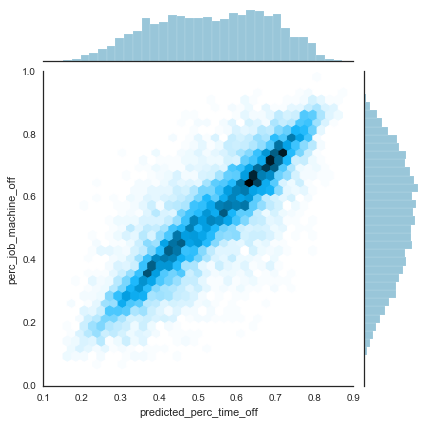

In [100]:
joined = X.join(y)

with sns.axes_style('white'):
    sns.jointplot("predicted_perc_time_off", "perc_job_machine_off", joined, kind='hex');

In [101]:
joined['delta'] = joined.perc_job_machine_off - joined.predicted_perc_time_off

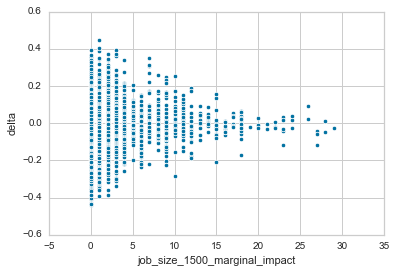

In [102]:
sns.scatterplot(y="delta", x="job_size_1500_marginal_impact", data=joined)

### moment of truth! let's regress this baby boo with the predicted values of perc_off_time instead! For machine A we are at 80% explainability!

In [103]:
y = dataCopy[dataCopy.MM_A==1].speed_std

# Note the difference in argument order
model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              speed_std   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     119.7
Date:                Thu, 21 Nov 2019   Prob (F-statistic):               0.00
Time:                        21:45:54   Log-Likelihood:                -69556.
No. Observations:                8564   AIC:                         1.397e+05
Df Residuals:                    8293   BIC:                         1.416e+05
Df Model:                         270                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
bucket_size_avg                   0.3605      7.835      0.046      0.963     -14.997      15.718
has_bucket_adds                 110.2790     36.348      3.034      0.002      39.028     181.530
job_size_1500_marginal_impact    61.6838      4.428     13.929      0.000      53.003      70.364
MM_A                           3326.2616     40.831     81.465      0.000    3246.223    3406.300
MM_B                          -1.157e-12   1.91e-12     -0.606      0.544    -4.9e-12    2.58e-12
MM_C                          -7.817e-12   2.29e-12     -3.411      0.001   -1.23e-11   -3.33e-12
MM_D                          -2.398e-12   2.03e-12     -1.182      0.237   -6.37e-12    1.58e-12
MM_E                           5.691e-12   1.68e-12      3.395      0.001     2.4e-12    8.98e-12
A                              2303.6663     32.789     70.258      0.000    2239.392    2367.941
B                              1022.5953     42.741     23.925      0.000     938.812    1106.379
C                              5.473e-12   2.88e-12      1.902      0.057   -1.69e-13    1.11e-11
day_of_week                      -6.7746      6.092     -1.112      0.266     -18.716       5.167
start_off_hours                 992.1956     18.464     53.735      0.000     956.001    1028.391
start_morning                  1032.1540     18.980     54.380      0.000     994.947    1069.361
start_afternoon                1301.9120     20.965     62.101      0.000    1260.816    1343.008
W0001                           235.3354    825.058      0.285      0.775   -1381.984    1852.655
W0002                          1301.8153    170.689      7.627      0.000     967.222    1636.409
W0003                          1722.1069    120.848     14.250      0.000    1485.215    1958.999
W0004                          2590.0648    825.334      3.138      0.002     972.204    4207.925
W0005                          1385.8271    137.058     10.111      0.000    1117.159    1654.495
W0006                           563.8441    370.438      1.522      0.128    -162.307    1289.996
W0007                          -635.3119    477.479     -1.331      0.183   -1571.291     300.667
W0008                          -820.8698    251.319     -3.266      0.001   -1313.518    -328.222
W0009                          -318.2802    251.411     -1.266      0.206    -811.109     174.548
W0010                          -104.5035    583.787     -0.179      0.858   -1248.872    1039.865
W0011                          -134.5320    293.827     -0.458      0.647    -710.506     441.442
W0012                           648.7735    103.408      6.274      0.000     446.067     851.480
W0013                            81.7886    293.870      0.278      0.781    -494.271     657.848
W0014                            64.8574    2

In [104]:
deltas = abs(predictions - y)
mae = np.mean(deltas)

In [110]:
mae

594.2505169985158

In [105]:
# we'll compare these in a little bit to the RF MAE also...

In [106]:
predictions_v_actual = pd.DataFrame()

In [107]:
predictions_v_actual['actual'] = y

In [108]:
predictions_v_actual['predictions'] = predictions

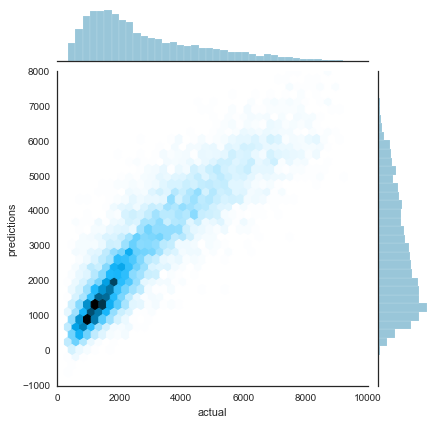

In [109]:
#THIS GRAPHIC SHOWS YOU THE CLOSENESS BETWEEN Y HAT AND Y-ACTUAL USING ONLY OLS. not bad!

joined = X.join(y)

with sns.axes_style('white'):
    sns.jointplot("actual", "predictions", predictions_v_actual, kind='hex');

In [83]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.25, random_state = 42)

## let's random forest this baby & see what's good!

In [84]:
# instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# train the model on training data
rf.fit(train_features, train_labels);

# use the predict method on the test data
predictions = rf.predict(test_features)
# calculate the absolute errors
errors = abs(predictions - test_labels)
print('mean absolute error:', round(np.mean(errors), 2), '.')

# calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# display accuracy
accuracy = 100 - np.mean(mape)
print('accuracy:', round(accuracy, 2), '%.')

mean absolute error: 794.91 .
accuracy: 62.27 %.


In [ ]:
# well... the MAE of the random forest unscaled is higher but it's being trained only on 80% of the data.
# these are not compared apples to apples and given high divergence of MAE on the linear regression... 

### Neural networks

In [111]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_features)
test_scaled = scaler.transform(test_features)

In [112]:
model = MLPRegressor()

In [113]:
model.fit(train_scaled, train_labels)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [114]:
predictions_train = model.predict(train_scaled)

In [112]:
r2_score(train_labels, predictions_train)

0.8383198206236194

our training set has 84% explainability :) (r-squared)

In [113]:
predictions_test = model.predict(test_scaled)

In [114]:
r2_score(test_labels, predictions_test)

0.695778453826047

70% r-squared with the testing set

In [115]:
mse = mean_squared_error(train_labels, model.predict(train_scaled))
mae = mean_absolute_error(train_labels, model.predict(train_scaled))
print("FOR TRAINING SET: mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))


FOR TRAINING SET: mse =  523005.47927638155  & mae =  512.5611235298951  & rmse =  723.1911775432424


In [116]:
test_mse = mean_squared_error(test_labels, model.predict(test_scaled))
test_mae = mean_absolute_error(test_labels, model.predict(test_scaled))
print("FOR TESTING SET: mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))


FOR TESTING SET: mse =  1001677.8535161148  & mae =  748.8009585638507  & rmse =  1000.838575153913


### k's nearest neighbors

In [95]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt


In [96]:
model = KNeighborsRegressor()

In [98]:
model.fit(train_scaled, train_labels)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [104]:
mse = mean_squared_error(train_labels, model.predict(train_scaled))
mae = mean_absolute_error(train_labels, model.predict(train_scaled))
print("FOR TRAINING SET: mse = ",mse," & mae = ",mae," & rmse = ", sqrt(mse))


mse =  575554.5944769157  & mae =  526.3820516469896  & rmse =  758.6531450385714


In [103]:
test_mse = mean_squared_error(test_labels, model.predict(test_scaled))
test_mae = mean_absolute_error(test_labels, model.predict(test_scaled))
print("FOR TESTING SET: mse = ",test_mse," & mae = ",test_mae," & rmse = ", sqrt(test_mse))


mse =  1123454.5902979644  & mae =  780.051341703321  & rmse =  1059.9314082986523


In [117]:
Recommendations:

# most of our unscaled MAE measurements suggest a linear regressor is fine if we are okay with 80% explainability.
# that gives us a wider margin for error on our outcome variable, with an MAE of roughly 600. 
# it is likely that a tree based approach can make improvements on this model if trained on a larger dataset.
# since the relationship between _most_ features and the outcome variable is NOT linear, 
# it is unlikely that we can improve predictability with a linear model.